**Meaning Classification with lambeq QNLP Toolkit**

Quantum Pipeline Simulation

This tutorial is based on - https://github.com/CQCL/lambeq/blob/main/docs/examples/quantum_pipeline_tket.ipynb

There are total 130 sentences in the data set where the training set has 70, development set has 30 and test set has 30. There are two kinds of sentences available which are related to either Maths or Music. This is a binary senence classification problem.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing necessary libraries**

In [ ]:
! pip install lambeq

     |████████████████████████████████| 100 kB 4.7 MB/s 
     |████████████████████████████████| 5.8 MB 15.0 MB/s 
     |████████████████████████████████| 364 kB 59.2 MB/s 
     |████████████████████████████████| 103 kB 80.3 MB/s 
  Created wheel for discopy: filename=discopy-0.3.7.1-py3-none-any.whl size=91600 sha256=9fb23695b60d12ad022d6e7cb86247fb1fb97ca088fad28f5abb90d1392410c4
  Stored in directory: /root/.cache/pip/wheels/dc/59/a1/9e765d9e150bad283ca03bf98c2c0ddd001f80078c3163e497
Successfully built discopy
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.10.1
    Uninstalling graphviz-0.10.1:
      Successfully uninstalled graphviz-0.10.1


In [ ]:
! pip install lambeq[depccg]

     |████████████████████████████████| 3.5 MB 3.2 MB/s 
     |████████████████████████████████| 880 kB 61.4 MB/s 
     |████████████████████████████████| 129 kB 67.6 MB/s 
     |████████████████████████████████| 78 kB 7.8 MB/s 
     |████████████████████████████████| 1.2 MB 46.2 MB/s 
  Created wheel for depccg: filename=depccg-1.1.0-cp37-cp37m-linux_x86_64.whl size=13855969 sha256=2197a0b16fb109cd754bf08c8b2e7cb1357327e9333db6565183f22bebe3557c
  Stored in directory: /root/.cache/pip/wheels/85/94/1c/1ae7b6d4d94fa629ebf0a55c3558486494a207740f50e64a51
  Created wheel for chainer: filename=chainer-6.0.0-py3-none-any.whl size=876785 sha256=a19e5679fab3444249b7aff94ae612309df407befdc388921ad1ead5538f9a9b
  Stored in directory: /root/.cache/pip/wheels/cd/38/53/18c6578a40a10ff120db266e58c5e383c1cb7bdea79b6c418a
  Created wheel for typing: filename=typing-3.7.4.3-py3-none-any.whl size=26324 sha256=2486f4cc3c01b3f4924b887347aecd5eef2ce494bc683741dd0719965b2f7db5
  Stored in directory: /root/.

In [ ]:
! depccg_en download

In [ ]:
!pip install pytket-qiskit

     |████████████████████████████████| 6.1 MB 4.9 MB/s 
     |████████████████████████████████| 17.9 MB 111 kB/s 
     |████████████████████████████████| 235 kB 51.2 MB/s 
     |████████████████████████████████| 207 kB 57.6 MB/s 
     |████████████████████████████████| 2.1 MB 48.8 MB/s 
     |████████████████████████████████| 207 kB 59.4 MB/s 
     |████████████████████████████████| 634 kB 42.8 MB/s 
     |████████████████████████████████| 1.4 MB 43.5 MB/s 
     |████████████████████████████████| 52 kB 1.5 MB/s 
     |████████████████████████████████| 49 kB 6.4 MB/s 
     |████████████████████████████████| 943 kB 47.8 MB/s 
     |████████████████████████████████| 38.2 MB 20 kB/s 
     |████████████████████████████████| 3.5 MB 45.3 MB/s 
     |████████████████████████████████| 6.3 MB 60.2 MB/s 
  Created wheel for pytket-qiskit: filename=pytket_qiskit-0.18.0-py3-none-any.whl size=36886 sha256=cb1f2b91ea0bd311327daaaa55281b3460af0cf6bac28071295ce5cb93b115f6
  Stored in directory: /root/

In [ ]:
!pip install noisyopt

**Reading the dataset and storing it in separate variables**

In [ ]:
import numpy as np

def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            labels.append([1, 0] if line[0] == '1' else [0, 1])
            sentences.append(line[1:].strip())
    return np.array(labels), sentences


train_labels, train_data = read_data('/content/drive/MyDrive/mm_mc_train_data.txt')
dev_labels, dev_data = read_data('/content/drive/MyDrive/mm_mc_dev_data.txt')
test_labels, test_data = read_data('/content/drive/MyDrive/mm_mc_test_data.txt')

**Parsing the sentences and converting them into string diagrams**

In [ ]:
from lambeq.ccg2discocat import DepCCGParser

reader = DepCCGParser(possible_root_cats=['S[dcl]'])

raw_train_diagrams = reader.sentences2diagrams(train_data)
raw_dev_diagrams = reader.sentences2diagrams(dev_data)
raw_test_diagrams = reader.sentences2diagrams(test_data)

**String diagram rewriting**

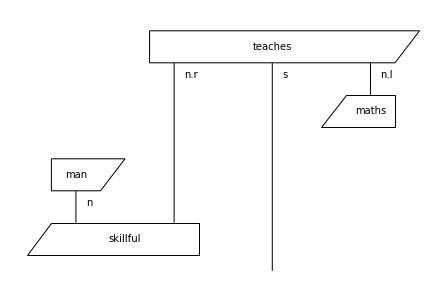

In [ ]:
from discopy.rigid import Id


def remove_cups(diagram):
    # Remove cups to reduce post-selection in the circuit, for faster execution

    diags = []
    for box, offset in zip(diagram.boxes, diagram.offsets):
        if not box.dom:  # word box
            diags.insert(offset, box)
        else:  # cup (the only other type of box in these diagrams)
            i = 0
            off = offset
            while off != len(diags[i].cod) - 1:
                assert off > 0
                off -= len(diags[i].cod)
                i += 1
            left, right = diags[i:i+2]
            
            if len(left.cod) == 1:
                new_diag = right >> (left.r.dagger() @ Id(right.cod[1:]))
            else:
                assert len(right.cod) == 1
                new_diag = left >> (Id(left.cod[:-1]) @ right.l.dagger())

            diags[i:i+2] = [new_diag]

    assert len(diags) == 1
    return diags[0]


train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]

train_diagrams[0].draw()

**Conversion of each diagram into a quantum circuit**

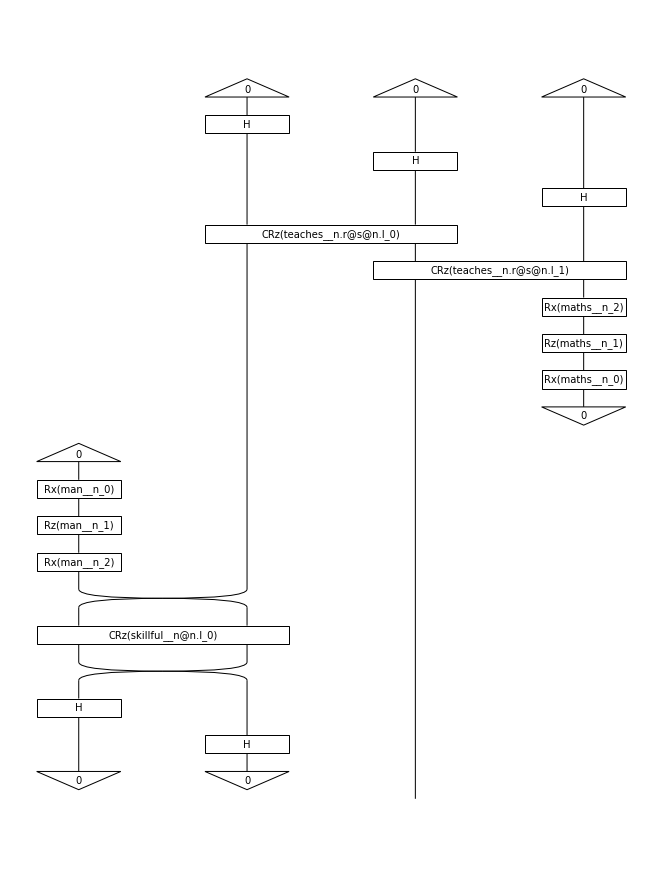

In [ ]:
from lambeq.circuit import IQPAnsatz
from lambeq.core.types import AtomicType

ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

train_circuits[0].draw(figsize=(9, 12))

**Sorting the symbols in quantum circuits to collect the parameters**

In [ ]:
from sympy import default_sort_key

all_circuits = train_circuits + dev_circuits + test_circuits

# sort the symbols since they are returned as a set
parameters = sorted(
    {s for circ in all_circuits for s in circ.free_symbols},
    key=default_sort_key)

**Defining the quantum simulator**

In [ ]:
## CONFIGURE BACKEND
# This uses Qiskit, which requires installing `pytket-qiskit`.
# For more information on how to use pytket with different backends, see:
# https://cqcl.github.io/pytket/build/html/extensions/

# Aer is a shots-based backend that is always available.

from pytket.extensions.qiskit import AerBackend
backend = AerBackend()

## Having an IBMQ account gives access to the IBM emulator for noisy simulations:
#
# from pytket.extensions.qiskit import IBMQEmulatorBackend
# backend = IBMQEmulatorBackend('PLACEHOLDER')
#
## To use a real device:
#
# from pytket.extensions.qiskit import IBMQBackend
# backend = IBMQBackend('PLACEHOLDER')

backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'n_shots': 8192  # maximum recommended shots, reduces sampling error
}

**Making predictions from the quantum circuits**

In [ ]:
from discopy.quantum import Circuit, Id, Measure


def randint(rng, low=-1 << 63, high=1 << 63-1):
    return rng.integers(low, high)


def normalise(predictions):
    # apply smoothing to predictions
    predictions = np.abs(predictions) + 1e-9
    return predictions / predictions.sum()


def make_pred_fn(circuits, rng):
    measured_circuits = [c >> Id().tensor(*[Measure()] * len(c.cod)) for c in circuits]
    circuit_fns = [c.lambdify(*parameters) for c in measured_circuits]

    def predict(params):
        outputs = Circuit.eval(*(c_fn(*params) for c_fn in circuit_fns),
                               **backend_config, seed=randint(rng))
        return np.array([normalise(output.array) for output in outputs])
    return predict


SEED = 0
rng = np.random.default_rng(SEED)

train_pred_fn = make_pred_fn(train_circuits, rng)
dev_pred_fn = make_pred_fn(dev_circuits, rng)
test_pred_fn = make_pred_fn(test_circuits, rng)

**Calculating cost function, accuracy and optimizing the circuit parameters**

In [ ]:
from noisyopt import minimizeSPSA

def make_cost_fn(pred_fn, labels):
    def cost_fn(params, **kwargs):
        predictions = pred_fn(params)

        cost = -np.sum(labels * np.log(predictions)) / len(labels)  # binary cross-entropy loss
        costs.append(cost)

        acc = np.sum(np.round(predictions) == labels) / len(labels) / 2  # half due to double-counting
        accuracies.append(acc)

        return cost

    costs, accuracies = [], []
    return cost_fn, costs, accuracies


train_cost_fn, train_costs, train_accs = make_cost_fn(train_pred_fn, train_labels)
dev_cost_fn, dev_costs, dev_accs = make_cost_fn(dev_pred_fn, dev_labels)

x0 = np.array(rng.random(len(parameters)))
np.random.seed(SEED)
result = minimizeSPSA(train_cost_fn, x0=x0, a=0.2, c=0.06, niter=80, callback=dev_cost_fn)

**Plotting the training & development set results**

Test accuracy: 0.8666666666666667


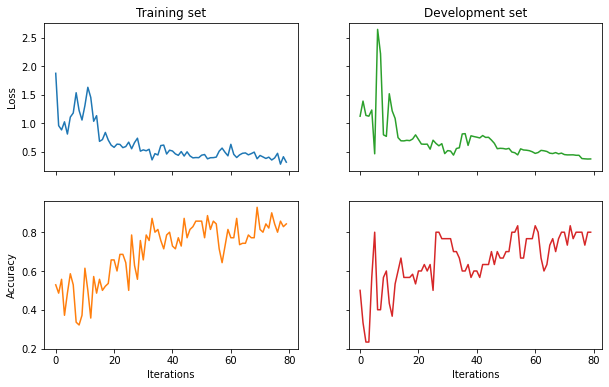

In [ ]:
import matplotlib.pyplot as plt

fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_tl.plot(train_costs[1::2], color=next(colours))  # training evaluates twice per iteration
ax_bl.plot(train_accs[1::2], color=next(colours))   # so take every other entry
ax_tr.plot(dev_costs, color=next(colours))
ax_br.plot(dev_accs, color=next(colours))

# print test accuracy
test_cost_fn, _, test_accs = make_cost_fn(test_pred_fn, test_labels)
test_cost_fn(result.x)
print('Test accuracy:', test_accs[0])